In [1]:
!pip install prophet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import csv
import pandas as pd
from prophet import Prophet

In [3]:
df = pd.read_csv('western_sentiment.csv')
print(df)

      Unnamed: 0            id                             created_at  \
0              0  1.496640e+18  2022-02-24 02:01:32 GTB Standard Time   
1              1  1.496640e+18  2022-02-24 02:02:33 GTB Standard Time   
2              2  1.496640e+18  2022-02-24 02:03:39 GTB Standard Time   
3              3  1.496640e+18  2022-02-24 02:15:19 GTB Standard Time   
4              4  1.496640e+18  2022-02-24 02:19:59 GTB Standard Time   
...          ...           ...                                    ...   
6405       16711  1.523790e+18  2022-05-10 01:29:11 GTB Daylight Time   
6406       16714  1.523790e+18  2022-05-10 01:39:12 GTB Daylight Time   
6407       16717  1.523800e+18  2022-05-10 01:50:34 GTB Daylight Time   
6408       16718  1.523800e+18  2022-05-10 01:57:50 GTB Daylight Time   
6409       16722  1.523800e+18  2022-05-10 02:13:02 GTB Daylight Time   

           date     time   username       name  \
0     2/24/2022  2:01:32  liveuamap  Liveuamap   
1     2/24/2022  2:02:3

In [4]:
columns = ['date','tweet','sentiment']
df = df.reindex(columns=columns)
print(df)

           date                                              tweet  sentiment
0     2/24/2022  UN Security Council to hold emergency session ...  -0.152493
1     2/24/2022  At 4:30 Kyiv time. Most urgent after years  ht...   1.326654
2     2/24/2022  Rare meeting of UNSC the same day(NY time) whe...  -0.862471
3     2/24/2022  Two Turkish Air Force Airbus A400M entered Ukr...   3.048466
4     2/24/2022  Another cyber attack targeting the website of ...   0.615685
...         ...                                                ...        ...
6405  5/10/2022  Video of the aftermath of an artillery strike ...   2.084022
6406  5/10/2022  Video from Odesa after todays strikes. 4/  ht...  -0.118575
6407  5/10/2022  Video of artillery strikes on Russia positions...   4.150844
6408  5/10/2022  Video of a low-flying Ukrainian Mi-24 helicopt...   1.616679
6409  5/10/2022  Video of a Ukrainian soldier firing an NLAW at...  -0.938575

[6410 rows x 3 columns]


In [5]:
df_pro=pd.DataFrame()
df_pro['ds'] = df['date']
df_pro['y'] = df['sentiment'].values
m=Prophet()
model=m.fit(df_pro)
days_in_future=100 #how many days in future to predict
future=m.make_future_dataframe(periods=days_in_future, freq = 'D',include_history = 'false') 
forecast=m.predict(future)
print(forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpghwcjjma/funxgi8u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpghwcjjma/adl2gl9c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22658', 'data', 'file=/tmp/tmpghwcjjma/funxgi8u.json', 'init=/tmp/tmpghwcjjma/adl2gl9c.json', 'output', 'file=/tmp/tmpghwcjjma/prophet_modeleaj9eql5/prophet_model-20230204213616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:36:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2022-02-24  2.112790   -0.907579    4.787523     2.112790     2.112790   
1   2022-02-25  2.125849   -0.606614    5.116807     2.125849     2.125849   
2   2022-02-26  2.138908   -0.473307    4.992450     2.138908     2.138908   
3   2022-02-27  2.151967   -0.717747    4.769265     2.151967     2.151967   
4   2022-02-28  2.165026   -0.736652    4.970438     2.165026     2.165026   
..         ...       ...         ...         ...          ...          ...   
171 2022-08-14  1.175656   -1.729861    4.064607     0.578241     1.727772   
172 2022-08-15  1.165244   -1.572495    3.988376     0.553636     1.726236   
173 2022-08-16  1.154832   -1.490401    4.173075     0.538325     1.726878   
174 2022-08-17  1.144420   -1.766118    3.975277     0.516496     1.726758   
175 2022-08-18  1.134008   -1.671169    4.113641     0.500018     1.726152   

     additive_terms  additive_terms_lower  additive_terms_upper

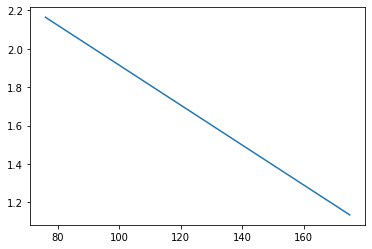

In [6]:
predicted=forecast[len(forecast)-days_in_future:len(forecast)]
predicted=predicted['trend']
predicted.plot()

In [22]:
!pip install mxnet gluonts ujson
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.mx import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean
import statistics
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
import numpy as np

df_glutons = df.copy()
df_glutons.month = pd.to_datetime(df_glutons['date'])
df_glutons.set_index("date",drop=True, inplace=True)
print(df_glutons)

training_data = ListDataset(
    [{"start": df_glutons.index[0], "target": df_glutons.sentiment[:"5/5/2022"], }],
    freq = "D"
)
test_data = ListDataset(
    [{"start": df_glutons.index[27], "target": df_glutons.sentiment["5/5/2022":"5/10/2022"], }],
    freq = "D"
)

callbacks = [
    LearningRateReduction(objective="min",
                          patience=10,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]

estimator = DeepAREstimator(
    freq="D",
    prediction_length=24,
    context_length=24,
    num_layers = 2,
    num_cells = 40,
    distr_output=StudentTOutput(),
    dropout_rate=0.01,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=50,
                    callbacks=callbacks))

predictor = estimator.train(training_data)
predictions = predictor.predict(test_data,100)
predictions = list(predictions)[0]
#print(predictions.samples)
final_results=[]
for arr in predictions.samples:
  final_results.append(np.median(arr))

print(final_results)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-22-c79db0bd5fa3>:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_glutons.month = pd.to_datetime(df_glutons['date'])


                                                       tweet  sentiment
date                                                                   
2/24/2022  UN Security Council to hold emergency session ...  -0.152493
2/24/2022  At 4:30 Kyiv time. Most urgent after years  ht...   1.326654
2/24/2022  Rare meeting of UNSC the same day(NY time) whe...  -0.862471
2/24/2022  Two Turkish Air Force Airbus A400M entered Ukr...   3.048466
2/24/2022  Another cyber attack targeting the website of ...   0.615685
...                                                      ...        ...
5/10/2022  Video of the aftermath of an artillery strike ...   2.084022
5/10/2022  Video from Odesa after todays strikes. 4/  ht...  -0.118575
5/10/2022  Video of artillery strikes on Russia positions...   4.150844
5/10/2022  Video of a low-flying Ukrainian Mi-24 helicopt...   1.616679
5/10/2022  Video of a Ukrainian soldier firing an NLAW at...  -0.938575

[6410 rows x 2 columns]


100%|██████████| 50/50 [00:08<00:00,  5.86it/s, epoch=50/50, avg_epoch_loss=1.33]


[1.2882364, 1.3980236, 1.8579043, 1.3781909, 1.54565, 1.1331924, 1.6106066, 1.470711, 1.4173747, 1.0127709, 1.2832025, 1.7622885, 1.1590569, 1.325552, 1.3583301, 1.7162126, 1.2793405, 1.2254456, 1.8762401, 1.2860513, 1.6542845, 1.3555624, 1.4969423, 1.862438, 1.7913499, 1.9497607, 1.4136554, 1.1219226, 1.1344783, 1.4752667, 1.478895, 1.7251911, 1.6425413, 1.2564797, 1.4536834, 0.9647418, 1.4804679, 2.2017136, 1.2947819, 1.741877, 0.98158014, 1.2982285, 1.1090372, 1.393713, 1.1648464, 1.2505983, 1.631433, 1.4507518, 1.5153625, 1.7314873, 1.6836363, 2.2498455, 2.0787754, 1.4000328, 1.8228152, 1.0881703, 1.664401, 1.4681591, 1.5793324, 1.2511251, 1.8185294, 1.6786997, 1.3539737, 1.3053331, 1.9354439, 1.5397338, 1.7731056, 1.6439312, 1.6309552, 1.9014858, 1.6647874, 1.6702118, 1.4509763, 1.8141348, 1.7084081, 1.6898762, 1.1110117, 1.4969823, 1.6938245, 1.5327604, 1.1131682, 1.0025511, 1.7426795, 1.5015808, 1.503611, 1.7701521, 1.2682958, 1.3156579, 1.5290399, 1.4917904, 1.2378666, 2.100675

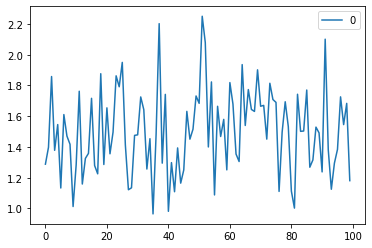

In [29]:
from array import array
f_res=np.array(final_results)
dff = pd.DataFrame(final_results)
dff.plot()